In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/matt/readout/host/')
import ali_offline_demod as dm
import imp
import glob
import pickle
from scipy import spatial
import h5py

/tmp/ipykernel_2649/3930659014.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [65]:
#path to beam map data
main_folder = '/home/matt/ali_drive_mnt/beam_map_data/'

#beam map directory
directory = 'toneinit_fcenter_4250.0_20240308061355_t_20240308062133/'

#file
file = glob.glob(main_folder + directory + '*.hd5')[0]

print(file)


#open file
tes_data = h5py.File(file, 'r')

print(list(tes_data['time_ordered_data'].keys()))

#channel
channel = 100

#t = np.array(tes_data['time_ordered_data']['timestamp'])
i = np.array(tes_data['time_ordered_data']['adc_i'][100])
#q = np.array(tes_data['time_ordered_data']['adc_q'][channel,:])

print(i)



/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133/ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5
['adc_i', 'adc_q', 'timestamp']
[-336  121  411 ... -318  118  459]


In [66]:
processed_data = dm.full_demod_process('ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5',
                                       f_sawtooth=15,
                                       n=1,
                                       tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations',
                                       ts_path = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133')
#normal demod process won't work because the datafile is too large; need to look at it in chunks

4250.0
20240308061355
/home/matt/ali_drive_mnt/tone_initializations/fcenter_4250.0_20240308061355/


MemoryError: Unable to allocate 59.4 GiB for an array with shape (1024, 15578912) and data type int32

In [16]:
#how many channels can we load at a time?

i = np.array(tes_data['time_ordered_data']['adc_i'][23:253][:])
print(i)

#python kernel begins to crash at around 200 channels, so let's chunck to 100 channels

# all we need to do is add an option to the top of the full demod process which channels to demod

[[-2040 -2937 -2973 ... -2047 -2954 -3003]
 [-1863 -1730 -2091 ... -1880 -1730 -2032]
 [  771   991  1765 ...   761   993  1772]
 ...
 [-1269 -1332 -1371 ... -1371 -1348 -1341]
 [  637  -138  -424 ...   126  -356  -512]
 [  216   -63  -199 ...    51  -180  -200]]


In [80]:
processed_data = dm.full_demod_process('ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5',
                                       f_sawtooth=15.0,
                                       n=2,
                                       channels='some',
                                       start_channel=190,
                                       stop_channel=192,
                                       tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations',
                                       ts_path = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133')

4250.0
20240308061355
/home/matt/ali_drive_mnt/tone_initializations/fcenter_4250.0_20240308061355/
[4.04455676e+09+0.j 4.04925600e+09+0.j 4.05118850e+09+0.j
 4.05330762e+09+0.j 4.05590806e+09+0.j 4.05714651e+09+0.j
 4.05850391e+09+0.j 4.06022866e+09+0.j 4.06400279e+09+0.j
 4.06518536e+09+0.j 4.06691971e+09+0.j 4.06885077e+09+0.j
 4.07034654e+09+0.j 4.07258089e+09+0.j 4.07523714e+09+0.j
 4.07763186e+09+0.j 4.07906134e+09+0.j 4.08002344e+09+0.j
 4.08284868e+09+0.j 4.08409877e+09+0.j 4.08759989e+09+0.j
 4.08895191e+09+0.j 4.09030945e+09+0.j 4.09184880e+09+0.j
 4.09499819e+09+0.j 4.09772073e+09+0.j 4.09861800e+09+0.j
 4.10045020e+09+0.j 4.10217871e+09+0.j 4.10407520e+09+0.j
 4.10644922e+09+0.j 4.10902227e+09+0.j 4.11095010e+09+0.j
 4.11852755e+09+0.j 4.12088477e+09+0.j 4.12305392e+09+0.j
 4.12532650e+09+0.j 4.12841797e+09+0.j 4.12940020e+09+0.j
 4.13167971e+09+0.j 4.13445870e+09+0.j 4.13665958e+09+0.j
 4.13860275e+09+0.j 4.14014127e+09+0.j 4.14199198e+09+0.j
 4.14425367e+09+0.j 4.14628811e

  0%|          | 0/2 [00:00<?, ?it/s]

In [82]:
%matplotlib qt
#print(processed_data)

channel = [1]#np.arange(0,10,1)

for i in channel:
    plt.plot(processed_data['demod t'],processed_data['demod data'][i])

In [59]:
print(len(processed_data['demod data'][1]))
print(len(processed_data['fr data'][1]))

478583
15578912


In [111]:
#processing an entire beam map file

beam_map_directory = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133'
tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations'
ts_file = glob.glob(f'{beam_map_directory}/*.hd5')[0]
print(ts_file)


#determine the number of channels using tone initialization
fcenter = beam_map_directory.split('_')[-4]
tone_init_t = beam_map_directory.split('_')[-3]
tone_init_directory = f'fcenter_{fcenter}_{tone_init_t}'
tone_init_freq_list = glob.glob(f'{tone_init_path}/{tone_init_directory}/freq_list_lo_sweep_targeted_1_*.npy')[0]
tones = np.load(tone_init_freq_list)
num_tones = len(tones)


if num_tones % 10 == 0:
    chunks = int(num_tones / 10)
else:
    chunks = int(num_tones // 10 + 1)

print(chunks)

for i in range(chunks):
    start_channel = start_channel + (stop_channel - start_channel)*i
    stop_channel = stop_channel + (stop_channel - start_channel)*i
    
    #truncated the final chunk if necessary
    if stop_channel > num_tones:
        stop_channel = num_tones
        
    processed_data = dm.full_demod_process(ts_file,
                                           f_sawtooth=15.0,
                                           n=2,
                                           channels='some',
                                           start_channel=start_channel,
                                           stop_channel=stop_channel,
                                           tone_init_path = tone_init_path,
                                           ts_path = beam_map_directory)
    
    #declare a filename for pickling
    file_name = 
    
    #pickle
    



#loop to read out and save to pickle files (need to name the pickle files using the channel ranges)


/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133/ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5


"\n#determine the number of channels using tone initialization\nfcenter = beam_map_directory.split('_')[-4]\ntone_init_t = beam_map_directory.split('_')[-3]\ntone_init_directory = f'fcenter_{fcenter}_{tone_init_t}'\ntone_init_freq_list = glob.glob(f'{tone_init_path}/{tone_init_directory}/freq_list_lo_sweep_targeted_1_*.npy')[0]\ntones = np.load(tone_init_freq_list)\nnum_tones = len(tones)\n\n\nif num_tones % 10 == 0:\n    chunks = int(num_tones / 10)\nelse:\n    chunks = int(num_tones // 10 + 1)\n\nprint(chunks)\n\nfor i in range(chunks):\n    start_channel = start_channel + (stop_channel - start_channel)*i\n    stop_channel = stop_channel + (stop_channel - start_channel)*i\n    \n    #truncated the final chunk if necessary\n    if stop_channel > num_tones:\n        stop_channel = num_tones\n        \n    processed_data = dm.full_demod_process('ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5',\n                                       f_sawtooth=15.0,\n                    

In [ ]:
#iv curves for 4250 MHz

# BL 9 - 20240212172504
iv_curve_file_4250MHz_BL9 = 'toneinit_fcenter_4250.0_20240212164634_t_20240212172504'

# BL 10 - 20240212171247
iv_curve_file_4250MHz_BL10 = 'toneinit_fcenter_4250.0_20240212164634_t_20240212171247'

# BL 11 - 20240212173240
iv_curve_file_4250MHz_BL11 = 'toneinit_fcenter_4250.0_20240212164634_t_20240212173240'



## Start Here

In [71]:
#process iv curve
iv_curves = {'4250MHz_BL9_Warm':'toneinit_fcenter_4250.0_20240212164634_t_20240212172504',
             '4250MHz_BL10_Warm':'toneinit_fcenter_4250.0_20240212164634_t_20240212171247',
             '4250MHz_BL11_Warm':'toneinit_fcenter_4250.0_20240212164634_t_20240212173240',
             '4750MHz_BL7_Warm':'toneinit_fcenter_4750.0_20240212174427_t_20240212174816',
             '4750MHz_BL8_Warm':'toneinit_fcenter_4750.0_20240212174427_t_20240212175959',
             '4750MHz_BL9_Warm':'toneinit_fcenter_4750.0_20240212174427_t_20240212180717',
             '4750MHz_BL11_Warm':'toneinit_fcenter_4750.0_20240212174427_t_20240212181437',
             '5250MHz_BL7_Warm':'toneinit_fcenter_5250.0_20240212182224_t_20240212182634', # -> problem here undiagnosed
             '5250MHz_BL9_Warm':'toneinit_fcenter_5250.0_20240212182224_t_20240212183347', # -> problem here
             '5250MHz_BL12_Warm':'toneinit_fcenter_5250.0_20240212182224_t_20240212184128',
             '5750MHz_BL8_Warm':'toneinit_fcenter_5750.0_20240212190328_t_20240212190721',
             '5750MHz_BL11_Warm':'toneinit_fcenter_5750.0_20240212190328_t_20240212191433',
             '6250MHz_BL8_Warm':'toneinit_fcenter_6250.0_20240212192226_t_20240212192618',
             '6750MHz_BL12_Warm':'toneinit_fcenter_6750.0_20240212193336_t_20240212193745',
             '4250MHz_BL9_Cold':'toneinit_fcenter_4250.0_20240213100705_t_20240213101047',
             '4250MHz_BL10_Cold':'toneinit_fcenter_4250.0_20240213100705_t_20240213101808',
             '4250MHz_BL11_Cold':'toneinit_fcenter_4250.0_20240213100705_t_20240213102551',
             '4750MHz_BL7_Cold':'toneinit_fcenter_4750.0_20240213103311_t_20240213103650',
             '4750MHz_BL8_Cold':'toneinit_fcenter_4750.0_20240213103311_t_20240213104400',
             '4750MHz_BL9_Cold':'toneinit_fcenter_4750.0_20240213103311_t_20240213105157',
             '4750MHz_BL11_Cold':'toneinit_fcenter_4750.0_20240213103311_t_20240213105928',
             '5250MHz_BL7_Cold':'toneinit_fcenter_5250.0_20240213110651_t_20240213111049',
             '5250MHz_BL9_Cold':'toneinit_fcenter_5250.0_20240213110651_t_20240213111823', #> problem here
             '5250MHz_BL12_Cold':'toneinit_fcenter_5250.0_20240213110651_t_20240213112541',
             '5750MHz_BL8_Cold':'toneinit_fcenter_5750.0_20240213114826_t_20240213115229',
             '5750MHz_BL11_Cold':'toneinit_fcenter_5750.0_20240213114826_t_20240213120017',
             '6250MHz_BL8_Cold':'toneinit_fcenter_6250.0_20240213120741_t_20240213121138',
             '6750MHz_BL12_Cold':'toneinit_fcenter_6750.0_20240213121929_t_20240213123317'}

#iv_processed_4250MHz_BL9 = dm.full_iv_process(iv_curves['4250MHz_BL9_Warm'],f_sawtooth=15, filter_Rn_Al=True, plot=None) 
iv_processed_4250MHz_BL10 = dm.full_iv_process(iv_curves['4250MHz_BL10_Warm'],f_sawtooth=15, filter_Rn_Al=True, plot=None) 
#iv_processed_4250MHz_BL11 = dm.full_iv_process(iv_curves['4250MHz_BL11_Warm'],f_sawtooth=15, filter_Rn_Al=True, plot=None) 

4250.0
20240212164634
/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240212164634/
num of channels: 1002
num of tones: 235
looking for delay region
start = 4047472656.2500253
stop = 4057492187.5000253
3.2552083333333246
n_phi0: 3.2552083333333246
start index: 20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

ValueError: cannot convert float NaN to integer

In [69]:
#view IV curves - find a good one to examine

active_channel = [3] #range(len(iv_processed_4250MHz_BL10))

for ch in active_channel:
    plt.plot(iv_processed_4250MHz_BL10['Vtes'][ch],iv_processed_4250MHz_BL10['Ites'][ch])
    print(f'Channel: {ch} Frequency: {np.real(iv_processed_4250MHz_BL10["time series data"]["channel freqs"][ch])}')

NameError: name 'iv_processed_4250MHz_BL10' is not defined

In [2]:
#look at the good iv curve's ts data
imp.reload(dm)

#ts_toneinit_fcenter_4250.0_20240221163542_t_20240221164159
#ts_toneinit_fcenter_4250.0_20240221163542_t_20240221164021

ts_file = 'ts_toneinit_fcenter_4250.0_20240221163542_t_20240221164159.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240221163542_t_20240221164021.hd5'

test_ts_processed = dm.full_demod_process(ts_file,
                                          f_sawtooth=15.0,
                                          n=0,
                                          channels='all')

4250.0
20240221163542
/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240221163542/
num of channels: 1002
num of tones: 230
looking for delay region


/home/matt/readout/host/ali_offline_demod.py:679: RuntimeWarning: divide by zero encountered in log10
  y=np.append(y,20*np.log10(np.abs(test_sweep[1,:])))


start = 4044848796.8750014
stop = 4054869304.6875014
3.2552083333333246
n_phi0: 3.2552083333333246
start index: 28


  0%|          | 0/230 [00:00<?, ?it/s]

In [73]:
#match channels from IV dataset to channels from TES source ts dataset
iv_freqs = iv_processed_4250MHz_BL10["time series data"]["channel freqs"]
ts_freqs = test_ts_processed["channel freqs"]

matched = dm.match_freqs(iv_freqs, ts_freqs)
print(matched[3])

[3 3]


/home/matt/readout/host/ali_offline_demod.py:1194: ComplexWarning: Casting complex values to real discards the imaginary part
  idups_ids=[fall[x,1].astype(int) for x in idups_redu]
/home/matt/readout/host/ali_offline_demod.py:1200: ComplexWarning: Casting complex values to real discards the imaginary part
  corrected_complex_data = apply_correction(eta_array, adc_i, adc_q)
/home/matt/readout/host/ali_offline_demod.py:1202: ComplexWarning: Casting complex values to real discards the imaginary part
  print(adc_q[22:25])


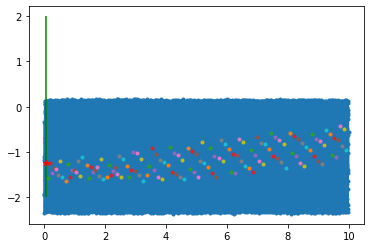

In [3]:
#view ts raw
active_channel = [3]#range(len(test_ts_processed['demod data']))
for ch in active_channel:
    plt.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][ch],'.-')
    for i in test_ts_processed['reset indices']:
        plt.plot(test_ts_processed['fr t'][test_ts_processed['start index']+i], test_ts_processed['fr data'][ch][test_ts_processed['start index']+i],'.')
    plt.vlines(test_ts_processed['t0']+test_ts_processed['fr t'][0],-2,2,'g')
    plt.plot(test_ts_processed['fr t'][test_ts_processed['start index']], test_ts_processed['fr data'][ch][test_ts_processed['start index']],'r*')
    

In [93]:
ch = 3


for i in range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][i]
    stop = test_ts_processed['reset indices'][i+2]
    plt.plot(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], test_ts_processed['fr data'][ch][start:stop],'.-')
    
#plt.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][ch],'--')

In [143]:
#view ts processed
active_channel = [3]#range(len(test_ts_processed['demod data']))

for ch in active_channel:
    plt.plot(test_ts_processed['demod t'], test_ts_processed['demod data'][ch])
    print(f'Channel: {ch} Frequency: {np.real(test_ts_processed["channel freqs"][ch])}')

Channel: 3 Frequency: 4053295757.8125496


In [9]:
processed_data = dm.full_demod_process('ts_toneinit_fcenter_4250.0_20240306105515_t_20240306110342.hd5',
                                       f_sawtooth=15.0,
                                       n=3,
                                       channels='some',
                                       start_channel=0,
                                       stop_channel=5,
                                       tone_init_path = '/home/matt/alicpt_data/tone_initializations',
                                       ts_path = '/home/matt/alicpt_data/beam_map_data/toneinit_fcenter_4250.0_20240306105515_t_20240306110300')

4250.0
20240306105515
/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240306105515/
[4.04455176e+09+0.j 4.04925974e+09+0.j 4.05117271e+09+0.j
 4.05331164e+09+0.j 4.05589432e+09+0.j 4.05716406e+09+0.j
 4.05847966e+09+0.j 4.06022559e+09+0.j 4.06399505e+09+0.j
 4.06523616e+09+0.j 4.06693178e+09+0.j 4.06890058e+09+0.j
 4.07040527e+09+0.j 4.07254771e+09+0.j 4.07527160e+09+0.j
 4.07761705e+09+0.j 4.07905259e+09+0.j 4.08008008e+09+0.j
 4.08285428e+09+0.j 4.08408691e+09+0.j 4.08758208e+09+0.j
 4.08896391e+09+0.j 4.09027051e+09+0.j 4.09189751e+09+0.j
 4.09497738e+09+0.j 4.09774300e+09+0.j 4.09864544e+09+0.j
 4.10049907e+09+0.j 4.10224419e+09+0.j 4.10404204e+09+0.j
 4.10646475e+09+0.j 4.10907817e+09+0.j 4.11093922e+09+0.j
 4.11852734e+09+0.j 4.12085161e+09+0.j 4.12300848e+09+0.j
 4.12528399e+09+0.j 4.12848235e+09+0.j 4.12940746e+09+0.j
 4.13168148e+09+0.j 4.13446196e+09+0.j 4.13669413e+09+0.j
 4.13855290e+09+0.j 4.14014277e+09+0.j 4.14197168e+09+0.j
 4.14430864e+09+0.j 4.14634989e+0

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
#match channels from IV dataset to channels from beam mapper dataset

iv_freqs = iv_processed_4250MHz_BL10["time series data"]["channel freqs"]
bm_freqs = processed_data["channel freqs"]

matched = dm.match_freqs(iv_freqs, ts_freqs)
print(matched[3])

[3 3]


In [12]:
#view beam map raw
%matplotlib qt
active_channel = [3]#range(len(test_ts_processed['demod data']))

for ch in active_channel:
    plt.plot(processed_data['fr t'], processed_data['fr data'][ch])
    print(f'Channel: {ch} Frequency: {np.real(processed_data["channel freqs"][ch])}')

Channel: 3 Frequency: 4098645437.5000505


In [190]:
#view beam map processed
active_channel = [3]#range(len(test_ts_processed['demod data']))

for ch in active_channel:
    plt.plot(processed_data['demod t'], processed_data['demod data'][ch])
    print(f'Channel: {ch} Frequency: {np.real(processed_data["channel freqs"][ch])}')

Channel: 3 Frequency: 4098645437.5000505


In [7]:
#chao-lin's interpolation idea

#generate flux ramp signal that matches the parameters we used during testing (this is for visuals)

fig, ax = plt.subplots(1)

sample_rate = 1000 #samples/s
start_t = 0 #s
end_t = 2/15 #s

f_sawtooth = 15 #Hz
n_Phi0 = 3.2368701718642683

t = np.arange(start_t,end_t,1/sample_rate)


t_fr, fr = dm.generate_flux_ramp(t, n_Phi0=n_Phi0, f_sawtooth=f_sawtooth, plot = False, plot_len = None)
average_fr = np.average(fr)


ax.plot(t_fr,fr-average_fr)

ch = 3


for i in range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][i]
    stop = test_ts_processed['reset indices'][i+2]
    average = np.average(test_ts_processed['fr data'][ch])
    ax.plot(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], test_ts_processed['fr data'][ch][start:stop]-average,'.-')
    

In [8]:
from scipy.interpolate import CubicSpline, interp1d

fig, ax = plt.subplots(1)

t_fr, fr = dm.generate_flux_ramp(t, n_Phi0=n_Phi0, f_sawtooth=f_sawtooth, plot = False, plot_len = None)
average_fr = np.average(fr)

ax.plot(t_fr,fr-average_fr)

demod_data = np.array([])
demod_t = np.array([])
for i in [0]:#range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][i]
    stop = test_ts_processed['reset indices'][i+2]
    average = np.average(test_ts_processed['fr data'][ch])
    
    interpolation = CubicSpline(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
                                test_ts_processed['fr data'][ch][start:stop]-average)
    t_new = np.linspace(0,test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start],1024)
    
    ax.plot(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
            test_ts_processed['fr data'][ch][start:stop]-average,
            '*')
    
    t_windowed = t_new#t_new[:len(t_new)-200]
    interp_windowed = interpolation(t_new)#[:len(t_new)-200]
    
    ax.plot(t_windowed,interp_windowed,'.-')
    
    num = np.sum(interp_windowed*np.sin(2*np.pi*n_Phi0*f_sawtooth*t_windowed))
    den = np.sum(interp_windowed*np.cos(2*np.pi*n_Phi0*f_sawtooth*t_windowed))
    
    
    #num = np.sum(interpolation(t_new)*np.sin(2*np.pi*n_Phi0*f_sawtooth*t_new))
    #den = np.sum(interpolation(t_new)*np.cos(2*np.pi*n_Phi0*f_sawtooth*t_new))
    
    demod_data = np.append(demod_data, np.arctan2(num, den))
    demod_t = np.append(demod_t, np.average(test_ts_processed['fr t'][start:stop])) #simple test is to make time the average time in the chunk

fig2, ax2 = plt.subplots(1)
ax2.plot(demod_t, demod_data,'.-')
    
    
    

In [9]:
"""
next steps:

single channel, break down the entire process step by step manually

1: define a good t0
2: identify all of the flux ramp reset points
3: attempt to demodulate on each resulting chunk
   a. use 1024 points or a smaller power of 2
   b. use actual fft to get first 3 terms
   c. reinject phase (try to reproduce the original data exactly)
   
   add to doc:
   synchronize the fr and detector sampling
   time spacing
"""

#raw data
fig, ax = plt.subplots(1)
ax.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][3],'.-')

#manually setting t0 to the 28th pt
t_t0shifted = test_ts_processed['fr t'][28:]
fr_t0shifted = test_ts_processed['fr data'][3][28:]
fig2, ax2 = plt.subplots(1)
ax2.plot(t_t0shifted,fr_t0shifted,'.-')

In [10]:
#trying out fft fitting method

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy

#first an initial test of the fft with a simple sine wave

sample_rate = 10 #Hz
frequency = 1 #Hz
phi = 0 #rad

t = np.arange(0,10,1/sample_rate)
signal = np.exp(-0.1*t)*np.sin(frequency*t+phi)


plt.plot(t,signal,'.')


signal_fft = fft(signal)

first_term = deepcopy(signal_fft)

np.put(first_term, np.arange(1,len(signal_fft),1).astype(int), 0.0)

first_term_ifft = ifft(first_term)

plt.plot(t, first_term_ifft,label='one term')

first_two_terms = deepcopy(signal_fft)
np.put(first_two_terms, np.arange(2,len(signal_fft),1).astype(int), 0.0)

first_two_terms_ifft = ifft(first_two_terms)

plt.plot(t, first_two_terms_ifft,label='two terms')

first_three_terms = deepcopy(signal_fft)
np.put(first_three_terms, np.arange(3,len(signal_fft),1).astype(int), 0.0)

first_three_terms_ifft = ifft(first_three_terms)

plt.plot(t, first_three_terms_ifft,label='three terms')

all_terms_ifft = ifft(signal_fft)
plt.plot(t, all_terms_ifft,label=f'{len(t)} terms (all)')

plt.legend()



/home/matt/.local/readout/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [11]:
#fft fitting method on our data
%matplotlib qt


fig, ax = plt.subplots(1)
ch = 3
ax.plot(test_ts_processed['fr t'],test_ts_processed['fr data'][ch],'.-')

#chunk and overplot
fig2, ax2 = plt.subplots(1)
for chunk in [0]:#range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
    stop = test_ts_processed['reset indices'][chunk+2]
    average = np.average(test_ts_processed['fr data'][ch])
    ax2.plot(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], test_ts_processed['fr data'][ch][start:stop]-average,'.-')
    
#interpolate (i.e., rebin)
fig3, ax3 = plt.subplots(1)
for chunk in [0]:#range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
    stop = test_ts_processed['reset indices'][chunk+2]
    average = np.average(test_ts_processed['fr data'][ch])
    
    interpolation = CubicSpline(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
                                test_ts_processed['fr data'][ch][start:stop]-average)
    t_new = np.linspace(0,test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start],1024)
    
    ax3.plot(t_new, interpolation(t_new),'.-')
    
#fit with fft

fig4, ax4 = plt.subplots(1)
for chunk in [0]:#range(len(test_ts_processed['reset indices'])-2):
    
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
    stop = test_ts_processed['reset indices'][chunk+2]
    average = np.average(test_ts_processed['fr data'][ch])
    
    interpolation = CubicSpline(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
                                test_ts_processed['fr data'][ch][start:stop]-average)
    t_new = np.linspace(0,test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start],1024)
    
    ax4.plot(t_new, interpolation(t_new),'.')

    fft_interpolation = fft(interpolation(t_new))
    
    first_term = deepcopy(fft_interpolation)
    np.put(first_term,np.arange(1,len(fft_interpolation),1),0.0)
    first_term_ifft = ifft(first_term)

    first_two_terms = deepcopy(fft_interpolation)
    np.put(first_two_terms,np.arange(2,len(fft_interpolation),1),0.0)
    first_two_terms_ifft = ifft(first_two_terms)

    first_three_terms = deepcopy(fft_interpolation)
    np.put(first_three_terms,np.arange(3,len(fft_interpolation),1),0.0)
    first_three_terms_ifft = ifft(first_three_terms)
    
    first_ten_terms = deepcopy(fft_interpolation)
    np.put(first_ten_terms,np.arange(10,len(fft_interpolation),1),0.0)
    first_ten_terms_ifft = ifft(first_ten_terms)
    
    first_twenty_terms = deepcopy(fft_interpolation)
    np.put(first_twenty_terms,np.arange(20,len(fft_interpolation),1),0.0)
    first_twenty_terms_ifft = ifft(first_twenty_terms)
    
    first_onehundred_terms = deepcopy(fft_interpolation)
    np.put(first_onehundred_terms,np.arange(100,len(fft_interpolation),1),0.0)
    first_onehundred_terms_ifft = ifft(first_onehundred_terms)
    
    first_onethousand_terms = deepcopy(fft_interpolation)
    np.put(first_onethousand_terms,np.arange(1000,len(fft_interpolation),1),0.0)
    first_onethousand_terms_ifft = ifft(first_onethousand_terms)
           
    
    all_terms_ifft = ifft(fft_interpolation)
    
    ax4.plot(t_new, first_term_ifft, label = 'n = 1')
    ax4.plot(t_new, first_two_terms_ifft, label = 'n = 2')
    ax4.plot(t_new, first_three_terms_ifft, label = 'n = 3')
    ax4.plot(t_new, first_ten_terms_ifft, label = 'n = 10')
    ax4.plot(t_new, first_twenty_terms_ifft, label = 'n = 20')
    ax4.plot(t_new, first_onehundred_terms_ifft, label = 'n = 100')
    ax4.plot(t_new, first_onethousand_terms_ifft, label = 'n = 1000')
    ax4.plot(t_new, all_terms_ifft, label = f'n = {len(fft_interpolation)} (all)')
    ax4.legend()


In [12]:
"""
After more conversations with Chao-Lin:

1. Need to zero pad (same length as original vector)
2. Look at the fft in frequency space; keep first 3 real terms
"""

fig, ax = plt.subplots(1)
fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
for chunk in [0]:#range(len(test_ts_processed['reset indices'])-2):
    
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
    stop = test_ts_processed['reset indices'][chunk+2]
    average = np.average(test_ts_processed['fr data'][ch])
    
    interpolation = CubicSpline(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
                                test_ts_processed['fr data'][ch][start:stop]-average)
    t_interp = np.linspace(0,test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start],1024)
    sig_interp = interpolation(t_interp)
    
    t_zero_pad = np.linspace(0,(test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start])*2,len(t_interp)*2)
    sig_zero_pad = np.append(sig_interp, np.zeros(len(sig_interp)))
    
    print(len(t_interp))
    print(len(sig_interp))
    print(len(t_zero_pad))
    print(len(sig_zero_pad))
    print(t_zero_pad)
    print(sig_zero_pad)
    
    ax.plot(t_interp, sig_interp,'.',label='interpolation')
    ax.plot(t_zero_pad, sig_zero_pad,'*',label='zero padded')

    fft_zero_pad = fft(sig_zero_pad)
    
    fftfreqs_zero_pad = fftfreq(len(sig_zero_pad), np.median(np.diff(t_zero_pad)))
    
    print(fft_zero_pad)
    
    print(fftfreqs_zero_pad)
    
    ax2.stem(fftfreqs_zero_pad, np.abs(fft_zero_pad))
    
    print(np.argmax(np.abs(fft_zero_pad)))
    
    fundamental_index = np.argmax(np.abs(fft_zero_pad))
    fundamental_freq = fftfreqs_zero_pad[fundamental_index]
    print(fundamental_freq)
    
    n1_fft = deepcopy(fft_zero_pad)
    np.put(n1_fft, np.arange(0,fundamental_index), 0.0)
    np.put(n1_fft, np.arange(fundamental_index+1, len(n1_fft)), 0.0)
    
    n1 = ifft(n1_fft) 
    
    ax.plot(t_zero_pad, n1)
    
    first_harmonic_index = fundamental_index * 2
    first_harmonic_freq = fftfreqs_zero_pad[first_harmonic_index]
    print(first_harmonic_freq)
    
    n2_fft = deepcopy(fft_zero_pad)
    np.put(n2_fft, np.arange(0,fundamental_index), 0.0)
    np.put(n2_fft, np.arange(fundamental_index+1,first_harmonic_index), 0.0)
    np.put(n2_fft, np.arange(first_harmonic_index+1,len(n2_fft)), 0.0)
    
    n2 = ifft(n2_fft)
    
    ax.plot(t_zero_pad, n2)
    
    nall = ifft(fft_zero_pad)
    
    ax.plot(t_zero_pad, nall)
        
    

ax2.set_xlim([0,100])
    
    
#next build a function that can build up to a desired number of terms and plot them    
    

1024
1024
2048
2048
[0.00000000e+00 7.40361505e-05 1.48072301e-04 ... 1.51403928e-01
 1.51477964e-01 1.51552000e-01]
[-0.33049692 -0.29080747 -0.25174734 ...  0.          0.
  0.        ]
[ 88.12417917 -0.j         -25.71196238+20.01709101j
 139.62498252 +3.9086978j  ... -38.30440106+19.13361391j
 139.62498252 -3.9086978j  -25.71196238-20.01709101j]
[  0.           6.5951734   13.1903468  ... -19.78552019 -13.1903468
  -6.5951734 ]
7
46.16621378305799
92.33242756611598


(0.0, 100.0)

In [13]:
def fft_fit(t, data, n):
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    fundamental_idx = np.argmax(np.abs(data_fft))
    print(f'fundamental index: {fundamental_idx}')
    
    multiplication_factors = np.arange(1,n+1,1)
    #print(multiplication_factors)
    fundamental_array = np.ones(n)*fundamental_idx
    #print(fundamental_array)
    preserve_idxs = (multiplication_factors * fundamental_array).astype(int)
    #print(preserve_idxs)

    mask = np.zeros(len(data_fft))
    np.put(mask,preserve_idxs,1.0)
    
    n_limited_fft = data_fft * mask
    
    n_limited_fit = ifft(n_limited_fft)
    
    full_fit = ifft(data_fft)
    
    return freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit

fig, ax = plt.subplots(1)
fig2, (ax2_upper, ax2_lower) = plt.subplots(2)

ax.plot(t_zero_pad, sig_zero_pad,'.',label='Raw Data')

for n in np.arange(1,21,1):
    freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit = fft_fit(t_zero_pad, sig_zero_pad, n)
    ax.plot(t_zero_pad, n_limited_fit,label=f'n = {n}')
    ax2_lower.stem(freqs, np.abs(n_limited_fft))
    


ax.plot(t, full_fit,'-.',label='all fft terms')
ax2_upper.stem(freqs, np.abs(data_fft))


ax.set_xlabel('t (s)')
ax.set_ylabel('Amplitude (arb.)')
ax.legend()

ax2_lower.set_xlim([-0.01,500])
ax2_upper.set_xlim([-0.01,500])
ax2_lower.set_xlabel('Frequency (Hz)')
ax2_lower.set_ylabel('Amplitude (arb.)')
ax2_upper.set_ylabel('Amplitude (arb.)')

fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7


Text(0, 0.5, 'Amplitude (arb.)')

In [14]:
fundamental_idx = 10
n = 20

multiplication_factors = np.arange(1,n+1,1)
fundamental_array = np.ones(n)*fundamental_idx
preserve_idxs = (multiplication_factors * fundamental_array).astype(int)
print(preserve_idxs)

#mask = np.zeros(len(data_fft))
#np.put(mask,preserve_idxs,1.0)
#print(mask)

#print(preserve_idxs)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]


In [287]:
"""
Next steps:
1. cut the reset region
2. zero pad (2N points)
3. fft fit as we have been doing (useful to plot real, imaginary, and abs)
4. Bin back to N points
"""
chunk = 0
zero_pad_multiple = 2

start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
stop = test_ts_processed['reset indices'][chunk+2]
average = np.average(test_ts_processed['fr data'][ch])

t_chunk = test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start]
sig_chunk = test_ts_processed['fr data'][ch][start:stop]-average

fig, ax = plt.subplots(1)
ax.plot(t_chunk,sig_chunk,'.--')
ax.set_xlabel('t (s)')
ax.set_ylabel('Amplitude (arb.)')
ax.set_title('Single FR Raw Data')

t_reset_removed = t_chunk[:-5] #just manually removing the reset for right now
sig_reset_removed = sig_chunk[:-5]

fig2, ax2 = plt.subplots(1)
ax2.plot(t_reset_removed,sig_reset_removed,'.--')
ax2.set_xlabel('t (s)')
ax2.set_ylabel('Amplitude (arb.)')
ax2.set_title('Reset Removed')

interpolation = CubicSpline(t_reset_removed,sig_reset_removed)

t_interp = np.linspace(0,t_reset_removed[-1]-t_reset_removed[0],1024)
sig_interp = interpolation(t_interp)

fig3, ax3 = plt.subplots(1)
ax3.plot(t_interp, sig_interp,'.')
ax3.set_xlabel('t (s)')
ax3.set_ylabel('Amplitude (arb.)')
ax3.set_title('N = 1024 pt. Cubic Spline Interpolation')

print(t_interp)
t_zero_pad = np.linspace(0,2*(t_interp[-1]-t_interp[0]),2*len(t_interp))#np.linspace(0,(t_interp[-1]-t_interp[0]),len(t_interp)*zero_pad_multiple)
print(t_zero_pad)
sig_zero_pad = np.append(sig_interp, np.zeros(len(sig_interp)*(zero_pad_multiple-1)))

fig4, ax4 = plt.subplots(1)
ax4.plot(t_zero_pad,sig_zero_pad,'.')
ax4.set_xlabel('t (s)')
ax4.set_ylabel('Amplitude (arb.)')
ax4.set_title(f'Zero Pad to {zero_pad_multiple}*N = {zero_pad_multiple*1024} pts.')

#make and check ffts
fig5, ax5 = plt.subplots(1) #fits with 2*N fft
fig6, (ax6_upper,ax6_lower) = plt.subplots(2) #2*N fft in freq space
fig7, ax7 = plt.subplots(1) #fits with N fft
fig8, (ax8_upper,ax8_lower) = plt.subplots(2) #N fft in freq space

ax5.plot(t_zero_pad,sig_zero_pad,'.',label='data')
ax7.plot(t_interp,sig_interp,'.',label='data')

first = 0
for n in np.arange(1,11,1):
    freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit = fft_fit(t_zero_pad, sig_zero_pad, n)
    ax5.plot(t_zero_pad, n_limited_fit,label=f'n = {n}')
    if first == 0:
        ax6_upper.stem(freqs, np.abs(n_limited_fft),'b', markerfmt='bo',label='abs')
        ax6_upper.stem(freqs, np.real(n_limited_fft),'r', markerfmt='ro',label='real')
        ax6_upper.stem(freqs, np.imag(n_limited_fft),'g', markerfmt='go',label='imag')
    else:
        ax6_upper.stem(freqs, np.abs(n_limited_fft),'b', markerfmt='bo')
        ax6_upper.stem(freqs, np.real(n_limited_fft),'r', markerfmt='ro')
        ax6_upper.stem(freqs, np.imag(n_limited_fft),'g', markerfmt='go')
    
    #bin back to n points
    freqs_rebinned = [np.average([freqs[i], freqs[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
    data_fft_rebinned = [np.average([data_fft[i], data_fft[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
    full_fit_rebinned = ifft(data_fft_rebinned)
    t_rebinned = t_interp#t_zero_pad[:int(len(t_zero_pad)/2)]
    n_limited_fft_rebinned = [np.average([n_limited_fft[i], n_limited_fft[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
    n_limited_fit_rebinned = ifft(n_limited_fft_rebinned)
    
    ax7.plot(t_rebinned, n_limited_fit_rebinned,label=f'n = {n}')
    if first == 0:
        ax8_upper.stem(freqs_rebinned, np.abs(n_limited_fft_rebinned),'b', markerfmt='bo',label='abs')
        ax8_upper.stem(freqs_rebinned, np.real(n_limited_fft_rebinned),'r', markerfmt='ro',label='real')
        ax8_upper.stem(freqs_rebinned, np.imag(n_limited_fft_rebinned),'g', markerfmt='go',label='imag')
    else:
        ax8_upper.stem(freqs_rebinned, np.abs(n_limited_fft_rebinned),'b', markerfmt='bo')
        ax8_upper.stem(freqs_rebinned, np.real(n_limited_fft_rebinned),'r', markerfmt='ro')
        ax8_upper.stem(freqs_rebinned, np.imag(n_limited_fft_rebinned),'g', markerfmt='go')

    first = 1
    
ax5.plot(t,full_fit,'-.',label='n = all')
    
ax6_lower.stem(freqs, np.abs(data_fft),'b', markerfmt='bo',label='abs')
ax6_lower.stem(freqs, np.real(data_fft),'r', markerfmt='ro',label='real')
ax6_lower.stem(freqs, np.imag(data_fft),'g', markerfmt='go',label='imag')
    
ax7.plot(t_rebinned,full_fit_rebinned,'-.',label='n = all')

ax8_lower.stem(freqs_rebinned, np.abs(data_fft_rebinned),'b', markerfmt='bo',label='abs')
ax8_lower.stem(freqs_rebinned, np.real(data_fft_rebinned),'r', markerfmt='ro',label='real')
ax8_lower.stem(freqs_rebinned, np.imag(data_fft_rebinned),'g', markerfmt='go',label='imag')
    
    
    
ax5.legend()
ax5.set_xlabel('t (s)')
ax5.set_ylabel('Amplitude (arb.)')
ax5.set_title('Data Fitting without Rebinning')
    
ax6_upper.set_xlim([-0.5,500])
ax6_lower.set_xlim([-0.5,500])
ax6_upper.legend()
ax6_lower.legend()
ax6_lower.set_xlabel('Frequency (Hz)')
ax6_lower.set_ylabel('Amplitude (arb.)')
ax6_upper.set_ylabel('Amplitude (arb.)')

ax7.legend()
ax7.set_xlabel('t (s)')
ax7.set_ylabel('Amplitude (arb.)')
ax7.set_title('Data Fitting with Rebinning')

ax8_upper.set_xlim([-0.5,500])
ax8_lower.set_xlim([-0.5,500])
ax8_upper.legend()
ax8_lower.legend()
ax8_lower.set_xlabel('Frequency (Hz)')
ax8_lower.set_ylabel('Amplitude (arb.)')
ax8_upper.set_ylabel('Amplitude (arb.)')


#check fits
#fig7, ax7 = plt.subplots(1)



#fig7, 

[0.00000000e+00 6.20606061e-05 1.24121212e-04 ... 6.33638788e-02
 6.34259394e-02 6.34880000e-02]
[0.00000000e+00 6.20302882e-05 1.24060576e-04 ... 1.26851939e-01
 1.26913970e-01 1.26976000e-01]
fundamental index: 6


/tmp/ipykernel_2649/1639219603.py:69: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_upper.stem(freqs, np.abs(n_limited_fft),'b', markerfmt='bo',label='abs')
/tmp/ipykernel_2649/1639219603.py:70: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_upper.stem(freqs, np.real(n_limited_fft),'r', markerfmt='ro',label='real')
/tmp/ipykernel_2649/1639219603.py:71: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_upper.stem(freqs, np.imag(n_limited_fft),'g', markerfmt='go',label='imag')
/tmp/ipykernel_2649/1639219603.py:87: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecate

fundamental index: 6
fundamental index: 6


/tmp/ipykernel_2649/1639219603.py:74: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_upper.stem(freqs, np.real(n_limited_fft),'r', markerfmt='ro')
/tmp/ipykernel_2649/1639219603.py:75: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_upper.stem(freqs, np.imag(n_limited_fft),'g', markerfmt='go')
/tmp/ipykernel_2649/1639219603.py:91: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax8_upper.stem(freqs_rebinned, np.abs(n_limited_fft_rebinned),'b', markerfmt='bo')
/tmp/ipykernel_2649/1639219603.py:92: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3

fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6


/tmp/ipykernel_2649/1639219603.py:99: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_lower.stem(freqs, np.abs(data_fft),'b', markerfmt='bo',label='abs')
/tmp/ipykernel_2649/1639219603.py:100: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_lower.stem(freqs, np.real(data_fft),'r', markerfmt='ro',label='real')
/tmp/ipykernel_2649/1639219603.py:101: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_lower.stem(freqs, np.imag(data_fft),'g', markerfmt='go',label='imag')
/tmp/ipykernel_2649/1639219603.py:105: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matp

Text(0, 0.5, 'Amplitude (arb.)')

In [286]:
"""
Now make sure I fold in the complex conjugate
adjust to make sure the dc offset is included
"""





#full fft
fig, ax = plt.subplots(1)
ax.stem(freqs, np.abs(data_fft))
ax.set_xlim([-500,500])




combined = data_fft[1]+data_fft[-1]




fundamental_idx = np.argmax(np.abs(data_fft))



#produce harmonic limited ffts
fixed_fundamental_fft = deepcopy(data_fft)
np.put(fixed_fundamental_fft,np.arange(0,fundamental_idx),0.0)
np.put(fixed_fundamental_fft,np.arange(fundamental_idx+1,len(data_fft)-fundamental_idx),0.0)
np.put(fixed_fundamental_fft,np.arange(len(data_fft)-fundamental_idx+1,len(data_fft)),0.0)

fixed_first_harmonic_fft = deepcopy(data_fft)
first_harmonic_idx = fundamental_idx*2
np.put(fixed_first_harmonic_fft,np.arange(0,fundamental_idx),0.0)
np.put(fixed_first_harmonic_fft,np.arange(fundamental_idx+1,first_harmonic_idx),0.0)
np.put(fixed_first_harmonic_fft,np.arange(first_harmonic_idx+1,len(data_fft)-first_harmonic_idx),0.0)
np.put(fixed_first_harmonic_fft,np.arange(len(data_fft)-first_harmonic_idx+1,len(data_fft)-fundamental_idx),0.0)
np.put(fixed_first_harmonic_fft,np.arange(len(data_fft)-fundamental_idx+1,len(data_fft)),0.0)

fixed_third_harmonic_fft = deepcopy(data_fft)
first_harmonic_idx = fundamental_idx*2
second_harmonic_idx = fundamental_idx*3
third_harmonic_idx = fundamental_idx*4
np.put(fixed_third_harmonic_fft,np.arange(0,fundamental_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(fundamental_idx+1,first_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(first_harmonic_idx+1,second_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(second_harmonic_idx+1,third_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(third_harmonic_idx+1,len(data_fft)-third_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(len(data_fft)-third_harmonic_idx+1,len(data_fft)-second_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(len(data_fft)-second_harmonic_idx+1,len(data_fft)-first_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(len(data_fft)-first_harmonic_idx+1,len(data_fft)-fundamental_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(len(data_fft)-fundamental_idx+1,len(data_fft)),0.0)

#print(fixed_fundamental_fft)

#produce fits
full_fit = ifft(data_fft)
fixed_fundamental_fit = ifft(fixed_fundamental_fft)
fixed_first_harmonic_fit = ifft(fixed_first_harmonic_fft)
fixed_third_harmonic_fit = ifft(fixed_third_harmonic_fft)

#first harmonic fft
fig2, ax2 = plt.subplots(1)
ax2.stem(freqs,np.abs(fixed_fundamental_fft))
ax2.set_xlim([-500,500])

#first harmonic fit
fig3, ax3 = plt.subplots(1)
ax3.plot(t_zero_pad, sig_zero_pad,'.')
ax3.plot(t_zero_pad, fixed_fundamental_fit)
ax3.plot(t_zero_pad, fixed_first_harmonic_fit)
ax3.plot(t_zero_pad, fixed_third_harmonic_fit)
freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit = fft_fit(t_zero_pad, sig_zero_pad, 1)
ax3.plot(t_zero_pad,full_fit,'-.')
#ax3.plot(t_zero_pad, n_limited_fit)

#third harmonic fft
fig4, ax4 = plt.subplots(1)
ax4.stem(freqs,np.abs(fixed_first_harmonic_fft))
ax4.set_xlim([-500,500])

#hird harmonic fit
fig5, ax5 = plt.subplots(1)
ax5.stem(freqs,np.abs(fixed_third_harmonic_fft))
ax5.set_xlim([-500,500])

"""
now implementing the rebinning from before [0,1],[1,2],[2,3],...
"""
freqs_rebinned = [np.average([freqs[i], freqs[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
data_fft_rebinned = [np.average([data_fft[i], data_fft[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
full_fit_rebinned = ifft(data_fft_rebinned)
t_rebinned = t_interp#t_zero_pad[:int(len(t_zero_pad)/2)]



fig6, ax6 = plt.subplots(1)
ax6.stem(freqs_rebinned,np.abs(data_fft_rebinned))

#^above doesn't rebin correctly; need to work from beginning to middle and end to middle rather than beginning to end

first_half_binning_array = np.arange(0,int(len(data_fft)/2),2)
#data_fft_rebinned_first_half = [np.average([data_fft[i], data_fft[i+1]]) for i in first_half_binning_array]
data_fft_rebinned_first_half = [np.average([data_fft[i], data_fft[i+1]]) for i in first_half_binning_array]
freqs_rebinned_first_half = [np.average([freqs[i], freqs[i+1]]) for i in first_half_binning_array]

#print(len(data_fft_rebinned_first_half))
#print(len(freqs_rebinned_first_half))

second_half_binning_array = np.arange(int((len(data_fft)/2)+2),int(len(data_fft)),2)
data_fft_rebinned_second_half = np.append([data_fft[0]+data_fft[int(len(data_fft)/2)]], [data_fft[i] + data_fft[i+1] for i in second_half_binning_array])
#freqs_rebinned_second_half = [np.average([freqs[i], freqs[i-1]]) for i in second_half_binning_array,2]

freqs_rebinned = np.append(freqs_rebinned_first_half,-np.flip(freqs_rebinned_first_half))

data_fft_rebinned = np.append(data_fft_rebinned_first_half,data_fft_rebinned_second_half)

fig7, ax7 = plt.subplots(1)
#ax7.stem(freqs_rebinned[:int(len(freqs_rebinned)/4)], np.abs(data_fft_rebinned_first_half))
ax7.stem(freqs_rebinned, np.abs(data_fft_rebinned))

#ax7.stem(freqs_rebinned[int(3*len(freqs_rebinned)/4):], np.abs(data_fft_rebinned_second_half))
 

#print(freqs_rebinned[:int(len(freqs_rebinned)/4)])
#print(freqs_rebinned[int(3*len(freqs_rebinned)/4):])
#print(freqs_rebinned)
#n_limited_fft_rebinned = [np.average([n_limited_fft[i], n_limited_fft[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
#n_limited_fit_rebinned = ifft(n_limited_fft_rebinned)

#^still not rebinning correctly: need to leave f=0 bin alone, bin [1,2], [2,3], [4,5], ...

first_half_binning_array = np.arange(1, int(len(data_fft)/2)-1,2)
second_half_binning_array = np.flip(np.arange(int((len(data_fft)/2)),int(len(data_fft)),2))
#print(second_half_binning_array)
#print(freqs[2046])
#print(freqs[1])

first_half_fft_rebinned = [np.average([data_fft[i],data_fft[i+1]]) for i in first_half_binning_array]
first_half_freqs_rebinned = [np.average([freqs[i],freqs[i+1]]) for i in first_half_binning_array]

second_half_fft_rebinned = [np.average([data_fft[i],data_fft[i+1]]) for i in second_half_binning_array]
second_half_freqs_rebinned = [np.average([freqs[i],freqs[i+1]]) for i in second_half_binning_array]#-np.flip(first_half_freqs_rebinned)


freqs_rebinned = np.append(0,first_half_freqs_rebinned)
freqs_rebinned = np.append(freqs_rebinned,np.flip(second_half_freqs_rebinned))
#freqs_rebinned = np.append(freqs[:len(freqs)]/4,-np.flip(freqs[:len(freqs)]/4))

fft_rebinned = np.append(data_fft[0],first_half_fft_rebinned)
fft_rebinned = np.append(fft_rebinned,np.flip(second_half_fft_rebinned))
#print(len(second_half_fft_rebinned))
#print(second_half_freqs_rebinned)

fig8, ax8 = plt.subplots(1)
ax8.stem(freqs_rebinned, np.abs(fft_rebinned))



#produce harmonic limited fft with rebinned total fft

fundamental_idx = np.argmax(np.abs(fft_rebinned))


rebinned_fixed_fundamental_fft = deepcopy(fft_rebinned)
np.put(rebinned_fixed_fundamental_fft,np.arange(0,fundamental_idx),0.0)
np.put(rebinned_fixed_fundamental_fft,np.arange(fundamental_idx+1,len(fft_rebinned)-fundamental_idx),0.0)
np.put(rebinned_fixed_fundamental_fft,np.arange(len(fft_rebinned)-fundamental_idx+1,len(fft_rebinned)),0.0)

rebinned_fixed_first_harmonic_fft = deepcopy(fft_rebinned)
first_harmonic_idx = fundamental_idx*2
np.put(rebinned_fixed_first_harmonic_fft,np.arange(0,fundamental_idx),0.0)
np.put(rebinned_fixed_first_harmonic_fft,np.arange(fundamental_idx+1,first_harmonic_idx),0.0)
np.put(rebinned_fixed_first_harmonic_fft,np.arange(first_harmonic_idx+1,len(fft_rebinned)-first_harmonic_idx),0.0)
np.put(rebinned_fixed_first_harmonic_fft,np.arange(len(fft_rebinned)-first_harmonic_idx+1,len(fft_rebinned)-fundamental_idx),0.0)
np.put(rebinned_fixed_first_harmonic_fft,np.arange(len(fft_rebinned)-fundamental_idx+1,len(fft_rebinned)),0.0)

rebinned_fixed_third_harmonic_fft = deepcopy(fft_rebinned)
first_harmonic_idx = fundamental_idx*2
second_harmonic_idx = fundamental_idx*3
third_harmonic_idx = fundamental_idx*4
np.put(rebinned_fixed_third_harmonic_fft,np.arange(0,fundamental_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(fundamental_idx+1,first_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(first_harmonic_idx+1,second_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(second_harmonic_idx+1,third_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(third_harmonic_idx+1,len(fft_rebinned)-third_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(len(fft_rebinned)-third_harmonic_idx+1,len(fft_rebinned)-second_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(len(fft_rebinned)-second_harmonic_idx+1,len(fft_rebinned)-first_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(len(fft_rebinned)-first_harmonic_idx+1,len(fft_rebinned)-fundamental_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(len(fft_rebinned)-fundamental_idx+1,len(fft_rebinned)),0.0)

#produce fits
rebinned_full_fit = ifft(fft_rebinned)
rebinned_fixed_fundamental_fit = ifft(rebinned_fixed_fundamental_fft)
rebinned_fixed_first_harmonic_fit = ifft(rebinned_fixed_first_harmonic_fft)
rebinned_fixed_third_harmonic_fit = ifft(rebinned_fixed_third_harmonic_fft)

#first harmonic fft
fig9, ax9 = plt.subplots(1)
ax9.stem(freqs_rebinned,np.abs(rebinned_fixed_fundamental_fft))
ax9.set_xlim([-500,500])



#third harmonic fft
fig10, ax10 = plt.subplots(1)
ax10.stem(freqs_rebinned,np.abs(rebinned_fixed_first_harmonic_fft))
ax10.set_xlim([-500,500])

#third harmonic fft
fig11, ax11 = plt.subplots(1)
ax11.stem(freqs_rebinned,np.abs(rebinned_fixed_third_harmonic_fft))
ax11.set_xlim([-500,500])

#harmonic fits
fig12, ax12 = plt.subplots(1)
ax12.plot(t_interp, sig_interp,'.')
ax12.plot(t_interp, rebinned_fixed_fundamental_fit)
ax12.plot(t_interp, rebinned_fixed_first_harmonic_fit)
ax12.plot(t_interp, rebinned_fixed_third_harmonic_fit)
ax12.plot(t_interp, ifft(fft_rebinned),'-.')
#freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit = fft_fit(t_interp, sig_interp, 1)
#ax10.plot(t_interp,full_fit,'-.')
#ax3.plot(t_zero_pad, n_limited_fit)


fundamental index: 6


In [152]:
np.arange(len(fft_rebinned)-fundamental_idx+1,len(data_fft))

np.abs((-0.3472529892708671-0.0004744514531811461j))

0.347253313392017

In [289]:
"""
Looked at the results above with chao-lin. Now we're going to try keeping the two highest peaks and their harmonics.
"""

#full fft
fig, ax = plt.subplots(1)
ax.stem(freqs, np.abs(data_fft))
ax.set_xlim([-500,500])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (arb.)')


def get_harmonic_fft(t, data, n):
    
    #find the the two fft terms with the most power
    
    data_fft = fft(data)
    
    fundamental_idx_1 = np.argmax(np.abs(data_fft))
    remove_highest = deepcopy(data_fft)
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    return data_fft_harmonics_only
    
    

data_fft_harmonics_only = get_harmonic_fft(t_zero_pad, sig_zero_pad, 1)
data_harmonics_only = ifft(data_fft_harmonics_only)


fig2, ax2 = plt.subplots(1)

ax2.stem(freqs,np.abs(data_fft_harmonics_only))
ax2.set_xlim([-500,500])

fig3, ax3 = plt.subplots(1)

ax3.plot(t_zero_pad, sig_zero_pad, '.')
ax3.plot(t_zero_pad, data_harmonics_only)

fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
ax4.plot(t_zero_pad, sig_zero_pad, '.',label='Interpolated Data')
for i in np.arange(1,11,1):
    data_fft_harmonics_only = get_harmonic_fft(t_zero_pad, sig_zero_pad, i)
    data_harmonics_only = ifft(data_fft_harmonics_only)
    ax4.plot(t_zero_pad, data_harmonics_only,label=f'n = {i}')
    ax5.stem(freqs,np.abs(data_fft_harmonics_only))
    
ax4.legend()
ax4.set_xlabel('t (s)')
ax4.set_ylabel('Amplitude (arb.)')

ax5.set_xlabel('Frequency (Hz)')
ax5.set_ylabel('Amplitude (arb.)')
ax5.set_xlim([-500,500])

#trying out phase plotting

data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)

threshold = max(np.abs(data_fft_phase_threshold))/10000

data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0

phase = np.arctan2(np.imag(data_fft_phase_threshold),np.real(data_fft_phase_threshold))*180/np.pi

fig6, ax6 = plt.subplots(1)
ax6.stem(freqs, phase)
ax6.set_xlim([-500,500])
ax6.set_xlabel('Frequency (Hz)')
ax6.set_ylabel('Phase (deg.)')


Text(0, 0.5, 'Phase (deg.)')

In [290]:
mask_1 = np.zeros(len(data_fft))
np.put(mask_1, [6, len(data_fft)-6], 1.0)
fft_bin_6 = data_fft*mask_1

mask_2 = np.zeros(len(data_fft))
np.put(mask_2, [7, len(data_fft)-7], 1.0)
fft_bin_7 = data_fft*mask_2


fig1, ax1 = plt.subplots(1)
ax1.stem(freqs, np.abs(fft_bin_6),markerfmt='bo',label = 'abs(fft)')
ax1.stem(freqs, np.real(fft_bin_6),markerfmt='ro',label = 'Re(fft)')
ax1.stem(freqs, np.real(fft_bin_6),markerfmt='go',label = 'Im(fft)')
ax1.legend()
ax1.set_xlim([-500,500])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude (arb.)')

fig2, ax2 = plt.subplots(1)
ax2.stem(freqs, np.abs(fft_bin_7),markerfmt='bo',label = 'abs(fft)')
ax2.stem(freqs, np.real(fft_bin_7),markerfmt='ro',label = 'Re(fft)')
ax2.stem(freqs, np.real(fft_bin_7),markerfmt='go',label = 'Im(fft)')
ax2.legend()
ax2.set_xlim([-500,500])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude (arb.)')


fig3, ax3 = plt.subplots(1)
ax3.plot(t_zero_pad, sig_zero_pad, '.',label='interpolated data')
ax3.plot(t_zero_pad, ifft(fft_bin_6),label='first peak')
ax3.plot(t_zero_pad, ifft(fft_bin_7),label='second peak')
ax3.plot(t_zero_pad, ifft(fft_bin_6+fft_bin_7),label='first peak + second peak')
ax3.legend()
ax3.set_xlabel('t (s)')
ax3.set_ylabel('Amplitude (arb.)')

data_fft_phase_threshold_bin_6 = deepcopy(fft_bin_6)
threshold = max(np.abs(data_fft_phase_threshold_bin_6))/10000
data_fft_phase_threshold_bin_6[np.abs(data_fft_phase_threshold_bin_6) < threshold] = 0.0

data_fft_phase_threshold_bin_7 = deepcopy(fft_bin_7)
threshold = max(np.abs(data_fft_phase_threshold_bin_7))/10000
data_fft_phase_threshold_bin_7[np.abs(data_fft_phase_threshold_bin_7) < threshold] = 0.0

phase_bin_6 = np.arctan2(np.imag(data_fft_phase_threshold_bin_6),np.real(data_fft_phase_threshold_bin_6))*180/np.pi
phase_bin_7 = np.arctan2(np.imag(data_fft_phase_threshold_bin_7),np.real(data_fft_phase_threshold_bin_7))*180/np.pi

fig4, ax4 = plt.subplots(1)
ax4.stem(freqs,phase_bin_6)
ax4.set_xlim([-500,500])
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Phase (deg.)')

fig5, ax5 = plt.subplots(1)
ax5.stem(freqs,phase_bin_7)
ax5.set_xlim([-500,500])
ax5.set_xlabel('Frequency (Hz)')
ax5.set_ylabel('Phase (deg.)')

Text(0, 0.5, 'Phase (deg.)')